In [2]:
csv_text = """transaction_id,timestamp,account_id,amount,currency,merchant_id,merchant_country,txn_type,status,device_id,ip_address
T001,2025-09-01 09:00:00,A001,1200,USD,M001,US,debit,success,D001,192.168.1.10
T002,2025-09-01 09:05:00,A001,15000,USD,M002,UK,debit,success,D001,192.168.1.11
T003,2025-09-01 09:07:00,A002,200,USD,M003,US,debit,failed,D002,192.168.1.12
T004,2025-09-01 09:10:00,A003,7500,USD,M004,IN,credit,success,D003,192.168.1.13
T005,2025-09-01 09:15:00,A001,300,USD,M005,US,debit,success,D001,192.168.1.10
T006,2025-09-01 09:17:00,A001,400,USD,M005,US,debit,success,D001,192.168.1.10
T007,2025-09-01 09:18:00,A001,600,USD,M005,US,debit,success,D001,192.168.1.10
T008,2025-09-01 09:19:00,A001,250,USD,M005,US,debit,success,D001,192.168.1.10
T009,2025-09-01 09:20:00,A001,450,USD,M005,US,debit,success,D001,192.168.1.10
T010,2025-09-01 09:22:00,A004,22000,USD,M006,RU,debit,success,D004,192.168.1.14
"""
with open("transactions.csv", "w") as f:
    f.write(csv_text)
print("transactions.csv created (10 rows).")

transactions.csv created (10 rows).


In [3]:
import pandas as pd
df = pd.read_csv("transactions.csv", parse_dates=["timestamp"])
print("Rows:", len(df))
df.head(12)

Rows: 10


,transaction_id,timestamp,account_id,amount,currency,merchant_id,merchant_country,txn_type,status,device_id,ip_address
0,T001,2025-09-01 09:00:00,A001,1200,USD,M001,US,debit,success,D001,192.168.1.10
1,T002,2025-09-01 09:05:00,A001,15000,USD,M002,UK,debit,success,D001,192.168.1.11
2,T003,2025-09-01 09:07:00,A002,200,USD,M003,US,debit,failed,D002,192.168.1.12
3,T004,2025-09-01 09:10:00,A003,7500,USD,M004,IN,credit,success,D003,192.168.1.13
4,T005,2025-09-01 09:15:00,A001,300,USD,M005,US,debit,success,D001,192.168.1.10
5,T006,2025-09-01 09:17:00,A001,400,USD,M005,US,debit,success,D001,192.168.1.10
6,T007,2025-09-01 09:18:00,A001,600,USD,M005,US,debit,success,D001,192.168.1.10
7,T008,2025-09-01 09:19:00,A001,250,USD,M005,US,debit,success,D001,192.168.1.10
8,T009,2025-09-01 09:20:00,A001,450,USD,M005,US,debit,success,D001,192.168.1.10
9,T010,2025-09-01 09:22:00,A004,22000,USD,M006,RU,debit,success,D004,192.168.1.14


In [4]:
# Simple validation: check missing IDs, non-negative amounts, timestamp parseable
errors = []
if df['transaction_id'].isnull().any():
    errors.append("Missing transaction_id")
if (df['amount'] < 0).any():
    errors.append("Negative amounts found")
if df['timestamp'].isnull().any():
    errors.append("Unparseable timestamps")

print("Validation errors:", errors if errors else "None")

Validation errors: None


In [5]:
# Efficient time-window count using groupby + rolling
df = df.sort_values(['account_id', 'timestamp']).reset_index(drop=True)
df2 = df.set_index('timestamp')
# rolling count on a per-account group; uses a numeric column (amount) as the rolling target
df['tx_count_30m'] = df2.groupby('account_id')['amount'].rolling('30min').count().reset_index(level=0, drop=True).astype(int)
df.head(12)

,transaction_id,timestamp,account_id,amount,currency,merchant_id,merchant_country,txn_type,status,device_id,ip_address,tx_count_30m
0,T001,2025-09-01 09:00:00,A001,1200,USD,M001,US,debit,success,D001,192.168.1.10,NaN
1,T002,2025-09-01 09:05:00,A001,15000,USD,M002,UK,debit,success,D001,192.168.1.11,NaN
2,T005,2025-09-01 09:15:00,A001,300,USD,M005,US,debit,success,D001,192.168.1.10,NaN
3,T006,2025-09-01 09:17:00,A001,400,USD,M005,US,debit,success,D001,192.168.1.10,NaN
4,T007,2025-09-01 09:18:00,A001,600,USD,M005,US,debit,success,D001,192.168.1.10,NaN
5,T008,2025-09-01 09:19:00,A001,250,USD,M005,US,debit,success,D001,192.168.1.10,NaN
6,T009,2025-09-01 09:20:00,A001,450,USD,M005,US,debit,success,D001,192.168.1.10,NaN
7,T003,2025-09-01 09:07:00,A002,200,USD,M003,US,debit,failed,D002,192.168.1.12,NaN
8,T004,2025-09-01 09:10:00,A003,7500,USD,M004,IN,credit,success,D003,192.168.1.13,NaN
9,T010,2025-09-01 09:22:00,A004,22000,USD,M006,RU,debit,success,D004,192.168.1.14,NaN


In [6]:
rules_exceptions = []

# Rule: high amount > 10,000
HIGH_AMOUNT_THR = 10000
high_mask = df['amount'] > HIGH_AMOUNT_THR
for _, r in df[high_mask].iterrows():
    rules_exceptions.append({
        "transaction_id": r.transaction_id,
        "rule": "HIGH_AMOUNT",
        "severity": "HIGH",
        "value": r.amount,
        "reason": f"amount > {HIGH_AMOUNT_THR}"
    })

# Rule: velocity (>5 tx in 30 min)
VELOCITY_THR = 5
vel_mask = df['tx_count_30m'] > VELOCITY_THR
for _, r in df[vel_mask].iterrows():
    rules_exceptions.append({
        "transaction_id": r.transaction_id,
        "rule": "VELOCITY",
        "severity": "MEDIUM",
        "value": int(r.tx_count_30m),
        "reason": f"{r.tx_count_30m} tx in 30min"
    })

# Rule: blacklisted merchant countries (example)
BLACKLISTED_COUNTRIES = {"RU"}
blk_mask = df['merchant_country'].isin(BLACKLISTED_COUNTRIES)
for _, r in df[blk_mask].iterrows():
    rules_exceptions.append({
        "transaction_id": r.transaction_id,
        "rule": "COUNTRY_BLACKLIST",
        "severity": "HIGH",
        "value": r.merchant_country,
        "reason": "merchant country in blacklist"
    })


rules_df = pd.DataFrame(rules_exceptions)
print("Rule exceptions:", len(rules_df))
rules_df

Rule exceptions: 3


,transaction_id,rule,severity,value,reason
0,T002,HIGH_AMOUNT,HIGH,15000,amount > 10000
1,T010,HIGH_AMOUNT,HIGH,22000,amount > 10000
2,T010,COUNTRY_BLACKLIST,HIGH,RU,merchant country in blacklist


In [7]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Features: amount and tx_count_30m (expand as needed)
X = df[["amount", "tx_count_30m"]].fillna(0).to_numpy()

# fit model
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X)
scores = clf.decision_function(X)  # higher = more normal
pred = clf.predict(X)              # -1 = anomaly, 1 = normal

df['anomaly_score'] = scores
df['is_anomaly'] = pred == -1

anom_df = df[df['is_anomaly']][['transaction_id','amount','tx_count_30m','anomaly_score']]
print("Detected anomalies:", len(anom_df))
anom_df

Detected anomalies: 1


,transaction_id,amount,tx_count_30m,anomaly_score
9,T010,22000,NaN,-0.033529


In [8]:
# prepare anomaly exceptions
anom_exceptions = []
for _, r in anom_df.iterrows():
    anom_exceptions.append({
        "transaction_id": r.transaction_id,
        "rule": "ANOMALY",
        "severity": "MEDIUM",
        "value": float(r.amount),
        "reason": f"IsolationForest score {r.anomaly_score:.4f}"
    })
anom_df2 = pd.DataFrame(anom_exceptions)

# union
all_ex = pd.concat([rules_df, anom_df2], ignore_index=True, sort=False)
all_ex = all_ex[['transaction_id','rule','severity','value','reason']].drop_duplicates()
all_ex = all_ex.reset_index(drop=True)
all_ex

# save reports
import os, datetime
os.makedirs("reports", exist_ok=True)
today = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
report_csv = f"reports/risk_report_{today}.csv"
all_ex.to_csv(report_csv, index=False)
print("Saved report:", report_csv)

Saved report: reports/risk_report_20250905_155002.csv


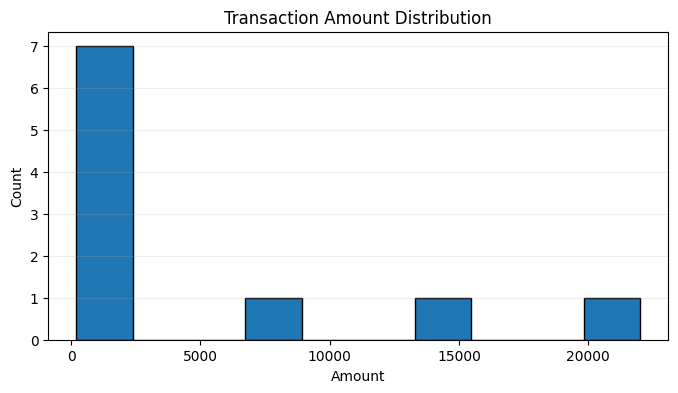

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df['amount'], bins=10, edgecolor="black")
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.2)
hist_path = f"reports/amount_hist_{today}.png"
plt.savefig(hist_path, bbox_inches='tight')
plt.show()

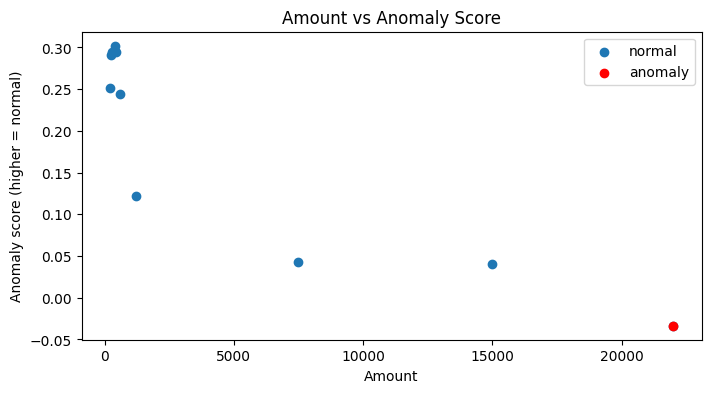

Saved charts: reports/amount_hist_20250905_155002.png reports/amount_vs_score_20250905_155002.png


In [10]:
# Scatter amount vs anomaly score, highlight anomalies
plt.figure(figsize=(8,4))
plt.scatter(df['amount'], df['anomaly_score'], label='normal')
plt.scatter(df[df['is_anomaly']]['amount'], df[df['is_anomaly']]['anomaly_score'], color='red', label='anomaly')
plt.xlabel('Amount')
plt.ylabel('Anomaly score (higher = normal)')
plt.title('Amount vs Anomaly Score')
plt.legend()
scatter_path = f"reports/amount_vs_score_{today}.png"
plt.savefig(scatter_path, bbox_inches='tight')
plt.show()

print("Saved charts:", hist_path, scatter_path)